**Purpose :** of this notebook is to take the clean AppleHealthKit data and aggregate it based on individual (each persons) parameters in order to cluster individuals that sync their historic behavior to Ongo (Notebook 3 in Part A)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("df_clean.csv", parse_dates=["startdate","enddate"])
df.head(2)

,_id,owner,easy_id,source,type,startdate,enddate,value,continent,city
0,013dbe8e-4388-571a-a475-46cdccb95124,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-heart-rate,2019-05-03 14:53:31.783,2019-05-03 14:53:31.783,100.000000,America,New_York
1,01cfa004-e070-59a9-9044-a33df3d0e5ed,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-step-distance,2019-06-28 16:59:51.148,2019-06-28 16:59:53.706,2.549228,America,New_York


In [3]:
dicti2 = {}
for i in df['easy_id'].unique():
    filt = df['easy_id']==i
    dicti2[i]=df.loc[filt,'owner'].unique()[0]

### Aggregate and then we can join between different tables ###

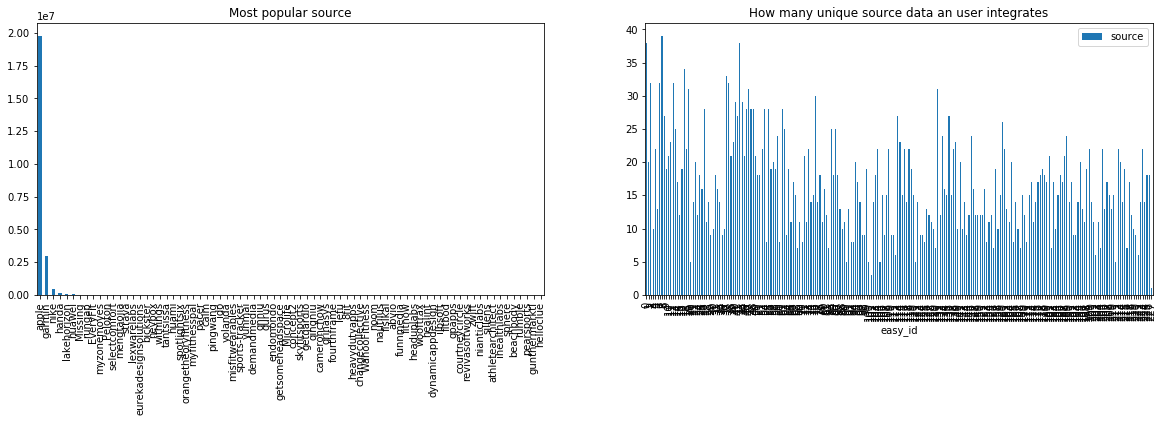

In [4]:
#1# source
fig, axes = plt.subplots(1,2, figsize = (20,5), gridspec_kw = {'wspace':0.20, 'hspace':0.40})
df['source'].value_counts().plot(kind='bar',ax=axes[0], title='Most popular source');

# Who many devices each use #1 aggregated column
agg_source = df.groupby('easy_id').agg({'source':'nunique'})
agg_source.plot(kind='bar',ax=axes[1], title='How many unique source data an user integrates');

#### 3rd party integration
- Most data from Apple
- Some people (who synced their data) use too many devices that they use within a few months

In [5]:
#3#4# startdate_enddata-datetime columns
duration = df['enddate'] - df['startdate']
df['duration_min'] = duration.dt.seconds/60

# duration of activities is max 1 days, so we can extract of weekdays/month from either startdate OR enddate
print(f'Max duration of the activity: {round(duration.dt.seconds.max()/3600,4)} hours')
# All data from 2019
df['enddate'].dt.year.unique()[0]

Max duration of the activity: 23.9997 hours


2019

### Monthly data analysis

In [6]:
# Extracting monthly data # Aggregate 2
df['month_name'] = df['startdate'].dt.month_name()
agg_monthly = df.groupby('easy_id').agg({'month_name':['nunique','count']})
agg_monthly.columns = ['months_active', 'count_month']
agg_monthly['avg_count_month'] = agg_monthly['count_month']/agg_monthly['months_active']

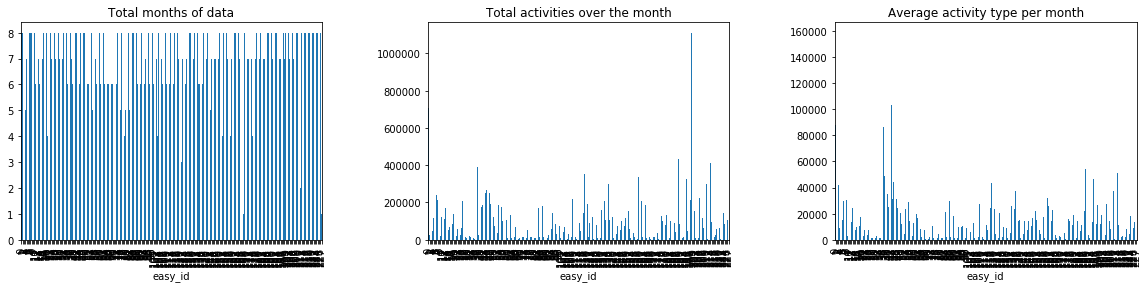

In [7]:
fig, axes = plt.subplots(1,3, figsize = (20,4), gridspec_kw = {'wspace':0.35, 'hspace':0.40})
axes = axes.ravel()
title = ['Total months of data', 'Total activities over the month', 'Average activity type per month']
for i in range(len(agg_monthly.columns)):
    agg_monthly[agg_monthly.columns[i]].plot(kind='bar', ax=axes[i])
    axes[i].set_title(title[i])

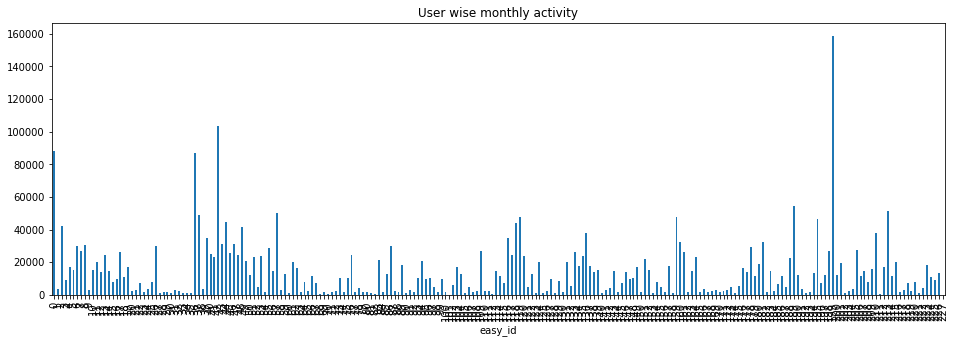

In [8]:
# Aggregate 3
agg_monthly2 = df.groupby('easy_id').month_name.value_counts().unstack()
agg_monthly2.mean(axis=1).plot(kind='bar', figsize=(16,5), title='User wise monthly activity');

### Weekday

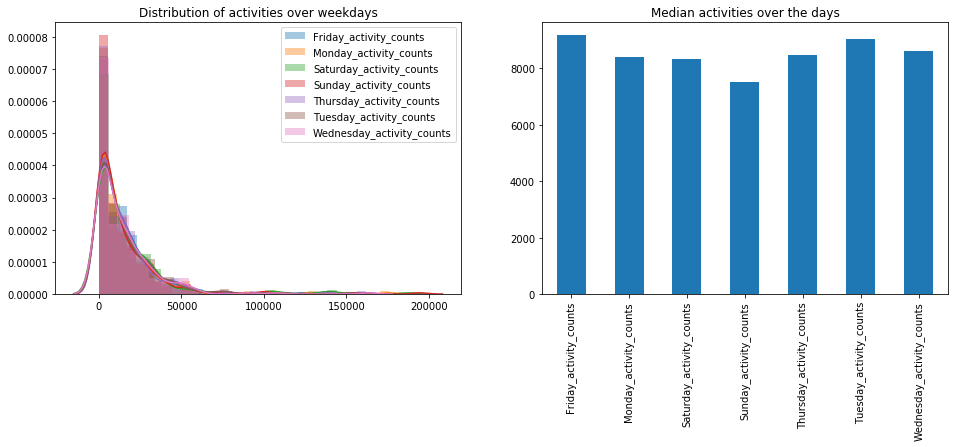

In [9]:
df['weekday_name'] = df['startdate'].dt.weekday_name
# how active weekday wise
agg_weekday = df.groupby('easy_id').weekday_name.value_counts().unstack()
agg_weekday.columns = [col+('_activity_counts') for col in agg_weekday.columns]

# Plotting weekday activities
fig, axis = plt.subplots(1,2, figsize=(16,5))
for col in agg_weekday.columns:
    sns.distplot(agg_weekday[col].fillna(0), ax=axis[0])
axis[0].set_xlabel('')
axis[0].legend(agg_weekday.columns,loc="upper right")
axis[0].set_title('Distribution of activities over weekdays')
agg_weekday.median(axis=0).plot(kind='bar', ax=axis[1])
axis[1].set_title('Median activities over the days');

Overall activities are similar over the weekday. A particular day doesn't seem to be totally different

### Weekday vs weekend analysis

In [10]:
# weekend more active or not?
df['weekend'] = df['weekday_name'].apply(lambda x: 1 if x in['Saturday','Sunday'] else 0)
agg_weekend = df.groupby('easy_id').weekend.value_counts().unstack()
agg_weekend2 = df.groupby('easy_id').agg({'weekend':['mean', 'std']})

### Hourly analysis

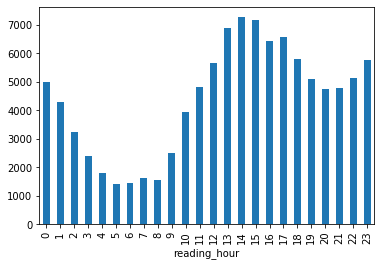

In [11]:
# Find out activities based on hour
df['reading_hour'] = df['startdate'].dt.hour
agg_hour = df.groupby('easy_id').reading_hour.value_counts().unstack()
agg_hour1 = agg_hour.mean(axis=1)
# aggregate column
agg_hour2 = df.groupby('easy_id').agg({'reading_hour':['mean', 'std']})
# hourly reading
agg_hour.mean(axis=0).plot(kind='bar')

* Most activities seem to pick up from 9, there is a dip in night time for obvious reasons which is clearly visible in the plot
* Later we need to explore whether some people more active in morning vs night

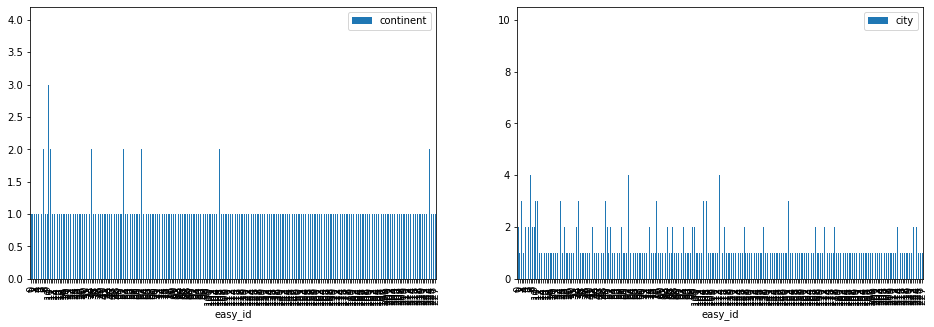

In [12]:
#6#7# Continent and City
agg_continent = df.groupby('easy_id').agg({'continent':'nunique'})
# Most likely won't be very good for prediction # aggregate column, people don't move across continent often
fig, axis = plt.subplots(1,2, figsize=(16,5))
agg_continent.plot(kind='bar', ax=axis[0])

agg_city = df.groupby('easy_id').agg({'city':'nunique'})
agg_city.plot(kind='bar', ax=axis[1]);

### Feature engineering and aggregation required for column-TYPE

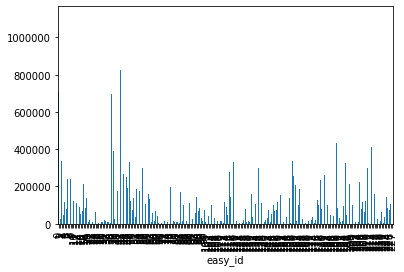

In [13]:
agg_type_count = df.groupby('easy_id').type.value_counts().unstack()
# aggregate column
agg_type_count_ = agg_type_count.sum(axis=1)
# How often users use the type activity
agg_type_count_.plot(kind='bar');

* Most data is avaialble for #health-heart-rate #health-step-count #health-step-distance
#health-flights-climbed #health-sleep 

### Relationship between type-value and continent

In [14]:
# Fuctions to visualize any obvious clusters among users
def plot_with_type_mean(activities, col, axis, axes=axes):
    axes = axes.ravel()
    for n,i in enumerate(activities):
        filt = df['type']==i
        df_new = df[filt]
        df_new = df_new.pivot_table(index='easy_id', columns=col, values='value',aggfunc='mean')                                                    
        df_new = df_new.mean(axis=axis)
        df_new.plot(kind='bar',ax=axes[n], title=i)
    fig.delaxes(axes[5])
def plot_with_type_median(activities, col, axis, axes=axes):
    axes = axes.ravel()
    for n,i in enumerate(activities):
        filt = df['type']==i
        df_new = df[filt]
        df_new = df_new.pivot_table(index='easy_id', columns=col, values='value',aggfunc='mean')                                                    
        df_new = df_new.median(axis=axis)
        df_new.plot(kind='bar',ax=axes[n], title=i)
    fig.delaxes(axes[5])
def plot_with_type_std(activities, col, axis, axes=axes):
    axes = axes.ravel()
    for n,i in enumerate(activities):
        filt = df['type']==i
        df_new = df[filt]
        df_new = df_new.pivot_table(index='easy_id', columns=col, values='value',aggfunc='mean')                                                    
        df_new = df_new.std(axis=axis)
        df_new.plot(kind='bar',ax=axes[n], title=i)
    fig.delaxes(axes[5])

In [15]:
# some continent data are too sparse
df['continent'].value_counts(normalize=True)

America      0.825543
Europe       0.089084
Asia         0.071463
Australia    0.009219
Pacific      0.003526
Africa       0.001149
Atlantic     0.000016
Name: continent, dtype: float64

In [16]:
main_continents = df['continent'].value_counts(normalize=True)
index = main_continents[main_continents<0.01].index
df['continent'] = df['continent'].replace({x:'Other_Continent' for x in index})
df['continent'].value_counts(normalize=True)

America            0.825543
Europe             0.089084
Asia               0.071463
Other_Continent    0.013910
Name: continent, dtype: float64

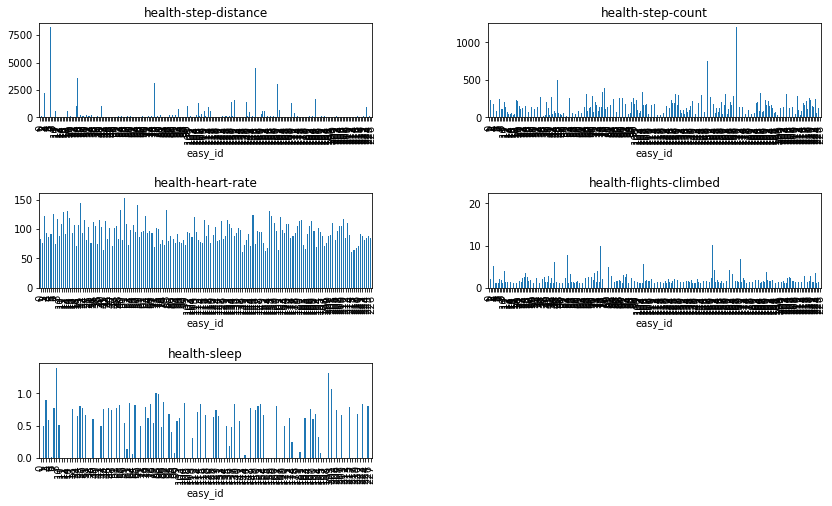

In [17]:
activities = ['health-step-distance','health-step-count','health-heart-rate','health-flights-climbed', 'health-sleep']
fig, axes = plt.subplots(3,2, figsize = (14,8), gridspec_kw = {'wspace':0.35, 'hspace':0.80})
plot_with_type_mean(activities=activities,col='continent', axis=1,axes=axes)

* If obvious outliers are removed, there are intuitive clusters based on type of activities

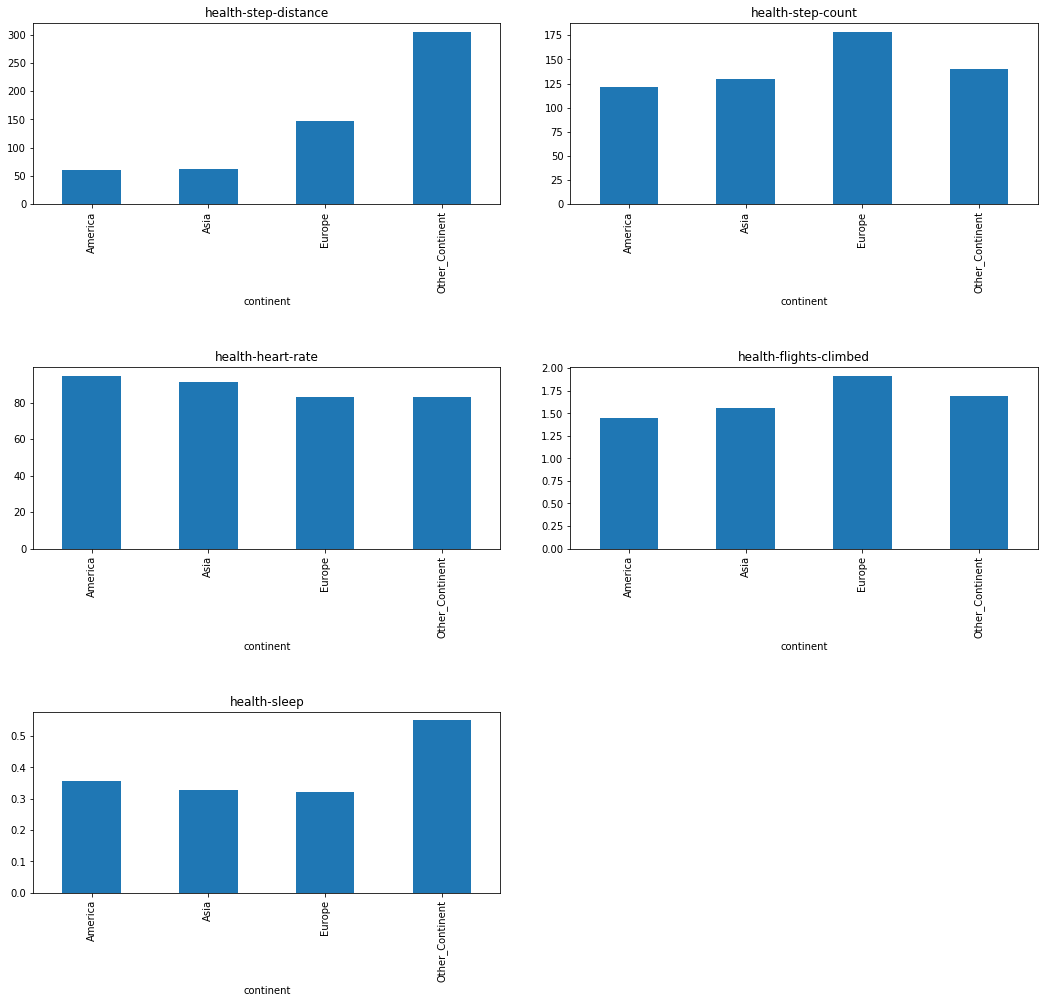

In [18]:
fig, axes = plt.subplots(3,2, figsize = (18,16), gridspec_kw = {'wspace':0.15, 'hspace':.90})
plot_with_type_median(activities=activities,col='continent', axis=0,axes=axes)

**Inference**
* Average heart rate is not affected based on which continent that person lives
* People in America and Europe have least sleep hours

### Relationship between type-value and continent

In [19]:
def aggregate_appleHealthKit_type(df,col):
    '''
    Finding each persons activity by pecific value per column. 
    Column name of the engineered features are pretty detailed to infer results. 
    '''
    df_list = []
    types = ['health-step-distance','health-step-count','health-flights-climbed'] 
    
    for i in range(len(types)):
        filt = df['type']==types[i]
        df2 = df[filt].pivot_table(index='easy_id', columns=col, values='value')
        df2.columns = [str(col)+'_'+types[i] for col in df2.columns]
        df_list.append(df2)
        df2_total = pd.DataFrame(df2.sum(axis=1))
        df2_total.columns = [types[i]+'_Total' for col1 in df2_total.columns]
        df_list.append(df2_total)
    return df_list

# continents and different types for each AppleHealthKit syncing customer
agg_continent_ = aggregate_appleHealthKit_type(df=df, col='continent')
data2 = [x for x in agg_continent_]
data2 = pd.concat(data2, axis=1)
data2.shape

(227, 15)

### Relationship between type-value and city

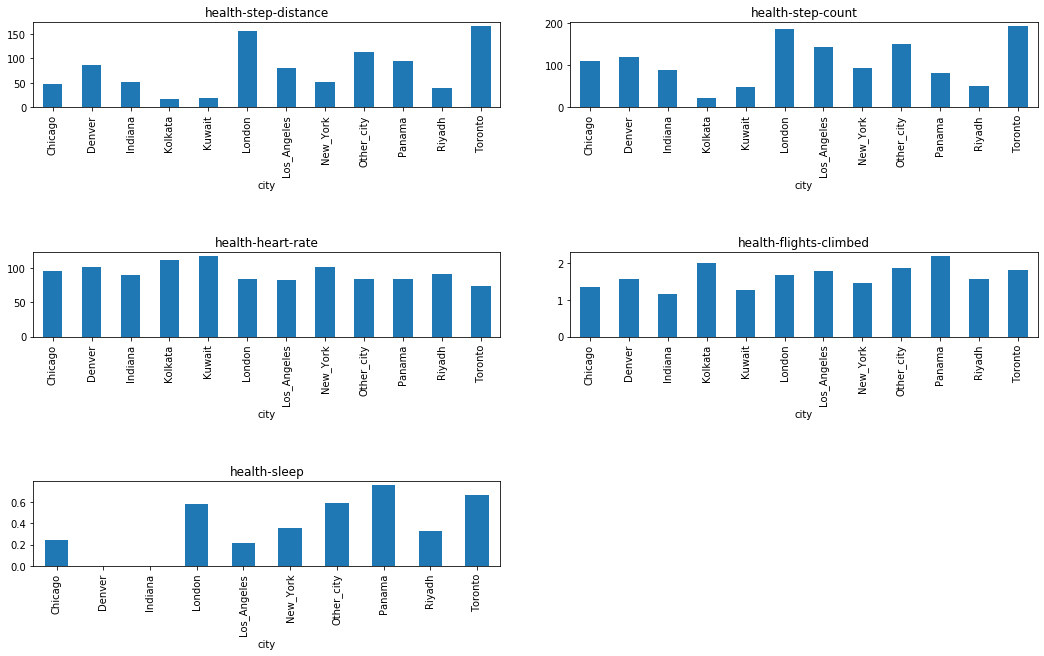

In [20]:
# Remove rare cities with 'Other'
main_cities1 = df['city'].value_counts(normalize=True)
index = main_cities1[main_cities1<0.01].index
df['city'] = df['city'].replace({x:'Other_city' for x in index})

# Visualize city based activities
fig, axes = plt.subplots(3,2, figsize = (18,10), gridspec_kw = {'wspace':0.15, 'hspace':1.7})
plot_with_type_median(activities=activities,col='city', axis=0,axes=axes)

**Inference**
* Genrally people in Toronto, London has covered a maximum step distance in meters.
* Whereas similar cities and LA seem to have maximum step count 
* interesting that higher heart rate is seen in Kuwait and London (probably they are less fit as they are less into walking as evident from step counts)

In [21]:
# cities and different types for each AppleHealthKit syncing customer
agg_city_ = aggregate_appleHealthKit_type(df=df, col='city')
data3 = [x for x in agg_city_]
data3 = pd.concat(data3, axis=1)
data3.shape

(227, 39)

### Relationship between type-value and source

Before removing outliers: 76
After removing outliers: 5




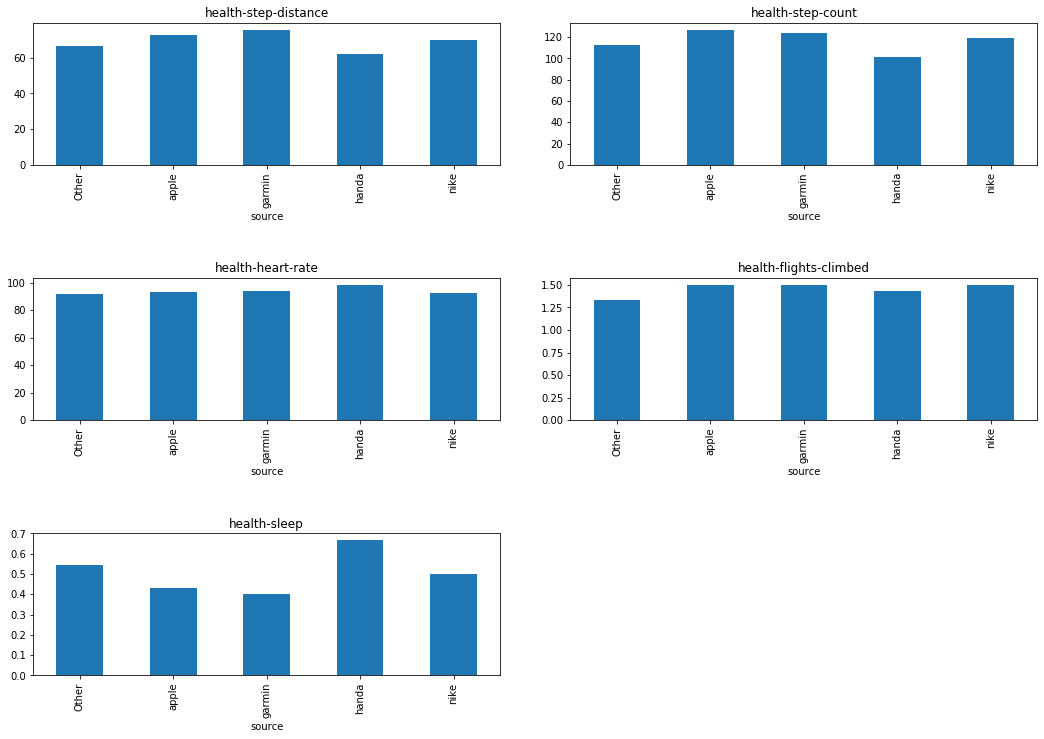

In [22]:
# A lot of source are outliers
main_source = df['source'].value_counts(normalize=True)
print(f'Before removing outliers: {len(main_source.index)}')

index = main_source[main_source<0.005].index
df['source'] = df['source'].replace({x:'Other' for x in index})
main_source = df['source'].value_counts(normalize=True)
print(f'After removing outliers: {len(main_source.index)}\n\n')

# Visualize source based activities
fig, axes = plt.subplots(3,2, figsize = (18,12), gridspec_kw = {'wspace':0.15, 'hspace':0.80})
plot_with_type_median(activities=activities,col='source', axis=0,axes=axes)

In [23]:
# source and different types for each AppleHealthKit syncing customer
agg_source_ = aggregate_appleHealthKit_type(df=df, col='source')
data4 = [x for x in agg_source_]
data4 = pd.concat(data4, axis=1)
data4.shape

(227, 18)

### Relationship between type-value and month name

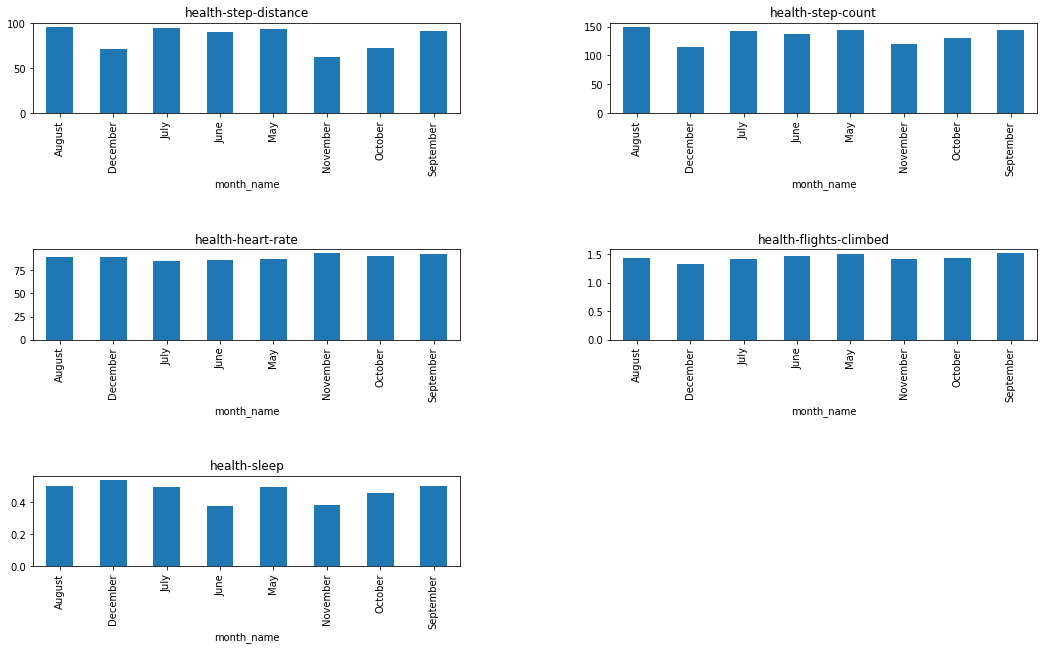

In [24]:
fig, axes = plt.subplots(3,2, figsize = (18,10), gridspec_kw = {'wspace':0.35, 'hspace':1.5})
plot_with_type_median(activities=activities,col='month_name', axis=0,axes=axes)

**Inference**<br>
* Avg heart rate is simlar across months
* Month doesnt have a huge impact on sleeping hours

In [25]:
# month_name and different types for each AppleHealthKit syncing customer
agg_month_ = aggregate_appleHealthKit_type(df=df, col='month_name')
data5 = [x for x in agg_month_]
data5 = pd.concat(data5, axis=1)
data5.shape

(227, 27)

### Relationship between type-value and weekend-weekday

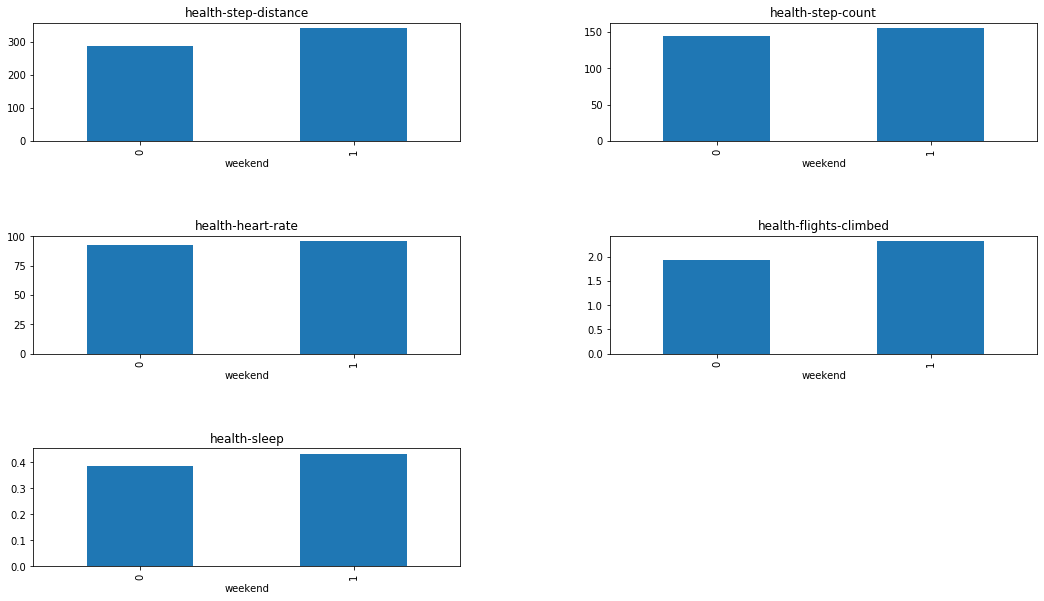

In [26]:
fig, axes = plt.subplots(3,2, figsize = (18,10), gridspec_kw = {'wspace':0.35, 'hspace':0.80})
plot_with_type_mean(activities=activities,col='weekend', axis=0,axes=axes)

In [27]:
# Weekday-Weekend and different types for each AppleHealthKit syncing customer
agg_weekend_ = aggregate_appleHealthKit_type(df=df, col='weekend')
data6 = [x for x in agg_weekend_]
data6 = pd.concat(data6, axis=1)
data6.shape

(227, 9)

### Relationship between type-value and weekday_name

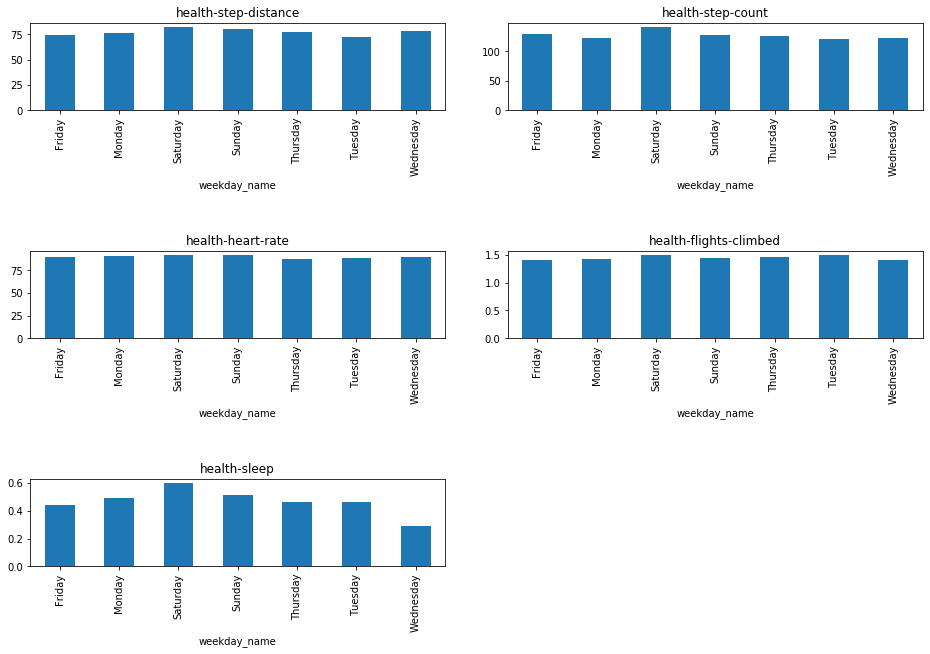

In [28]:
fig, axes = plt.subplots(3,2, figsize = (16,10), gridspec_kw = {'wspace':0.15, 'hspace':1.6})
plot_with_type_median(activities=activities,col='weekday_name', axis=0,axes=axes)

In [29]:
# Weekday-Weekend and different types for each AppleHealthKit syncing customer
agg_weekday_name = aggregate_appleHealthKit_type(df=df, col='weekday_name')
data7 = [x for x in agg_weekday_name]
data7 = pd.concat(data7, axis=1)
data7.shape

(227, 24)

### Relationship between type-value and Hour

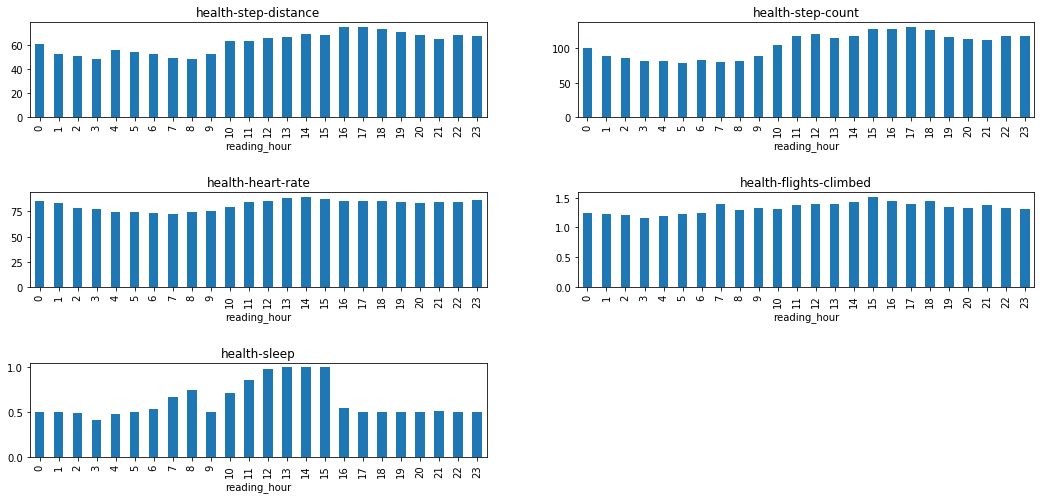

In [30]:
fig, axes = plt.subplots(3,2, figsize = (18,8), gridspec_kw = {'wspace':0.20, 'hspace':0.80})
plot_with_type_median(activities=activities,col='reading_hour', axis=0,axes=axes)

In [31]:
# Hourly activities for each AppleHealthKit syncing customer
agg_hour_ = aggregate_appleHealthKit_type(df=df, col='reading_hour')
data8 = [x for x in agg_hour_]
data8 = pd.concat(data8, axis=1)
data8.shape

(227, 75)

Hour based activities were later found to be NOT a very vital predictor except night-owl or morning person type of binning was effective. Hour based activities will not be included in the overall aggregated columns

### Here we will bucket peoples activity as night/morning activity to see if that falls in a cluster

In [32]:
dicti = {0:'Night person',1:'Night person',2:'Night person',3:'Night person',21:'Night person',22:'Night person',23:'Night person',
        5:'Morning person',6:'Morning person',7:'Morning person',8:'Morning person',9:'Morning person',
        10:'Morning person',11:'Morning person'}
df['Morning_Night_person'] = df['reading_hour'].map(dicti)
df['Morning_Night_person'].fillna('Normal hour', inplace=True)

hourly_activity = df.groupby('easy_id').Morning_Night_person.value_counts().unstack()
hourly_activity.columns = ['Total_Morning_activity', 'Total_Night_activity', 'Normal_Hour_activity']

avg_hourly_activity = df.pivot_table(index='easy_id', columns='Morning_Night_person', values='value', aggfunc='mean')
avg_hourly_activity.columns = ['Avg_Morning_activity', 'Avg_Night_activity', 'Avg_Hour_activity']

### Preparing all aggregated columns before concatenation

In [33]:
# Giving reasonable names to column to backtrack feature importance
agg_hour.columns = ['hour_'+str(i) for i in range(24)] 
agg_hour1 = pd.DataFrame(agg_hour1,columns= ['agg_hour_value_counts'])
agg_hour2.columns = ['userwise_hour_mean', 'userwise_hour_std']
agg_city.columns = ['userwise_city_no.'] 
agg_continent.columns =  ['userwise_continent_no']
agg_type_count_ = pd.DataFrame(agg_type_count_, columns=['userwise_total_activities'])
agg_type_count.columns = [col+'_'+'counts' for col in agg_type_count.columns]
agg_source.columns = ['Userwise No of devices synced'] #agg_monthly
agg_monthly2.columns = ['Total_Activity_'+str(i) for i in agg_monthly2.columns] 
agg_weekday.columns = ['Total_Activity_'+str(i) for i in agg_weekday.columns]
agg_weekend.columns = ['Total_activity_weekday', 'Total_activity_weekend']
agg_weekend2.columns = ['weekend_mean', 'weekend_std']

df_concat1 = pd.concat([agg_city,agg_continent,agg_type_count,agg_type_count_,  
                        agg_source,agg_weekend,agg_weekend2],axis=1) 
df_concat2 = pd.concat([data2, data3, data4, data6,  
                        hourly_activity, avg_hourly_activity],axis=1) 
# Putting all aggregated columns together
df_concat_total = pd.concat([df_concat1,df_concat2],axis=1)
df_concat_total.to_csv("df_concat_total.csv", index=True)
df_concat_total.shape

(228, 104)

* agg_monthly, agg_monthly2, data5 data7, data8, agg_hour, agg_hour1, agg_hour2, agg_weekday NOT selected to find columns that are more intuitive to make sense.

In [34]:
df_concat_total['owner'] = df_concat_total.index.map(dicti2)
df_concat_total.to_csv("df_concat_total.csv", index=True)
df_x = pd.read_csv("df_concat_total.csv")
df_x.head(2)

,easy_id,userwise_city_no.,userwise_continent_no,health-bmi_counts,health-body-fat_counts,health-flights-climbed_counts,health-heart-rate_counts,health-mindfulness-duration_counts,health-sleep_counts,health-step-count_counts,...,0_health-flights-climbed,1_health-flights-climbed,health-flights-climbed_Total.3,Total_Morning_activity,Total_Night_activity,Normal_Hour_activity,Avg_Morning_activity,Avg_Night_activity,Avg_Hour_activity,owner
0,0,2,1,71.0,71.0,101.0,354239.0,246.0,5021.0,57563.0,...,1.229508,1.400000,2.629508,64438.0,86740.0,553466.0,50.074889,51.793902,50.412481,f9946d46-0b26-444c-bf9f-d6322c0c0ce7
1,1,1,1,NaN,NaN,1502.0,1351.0,NaN,14.0,11711.0,...,1.868327,2.169312,4.037640,1712.0,10612.0,13897.0,134.558779,174.567047,178.612546,72664307-6d6c-46bc-ac90-6c79f223ef8e


In [75]:
########## Next: 3.AppleHealthKitData_Clustering_Classification_G ############